In [1]:
import sys
import os
import subprocess
import tarfile
import shutil
import random
from functools import partial
from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs
import pickle
from datetime import datetime
import scipy.stats as stats
import math

import boda
from boda.common import constants, utils

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
from pymeme import streme, parse_streme_output

from torch.distributions.categorical import Categorical
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm, counts_to_ppm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz'
unpack_artifact(hpo_rec)

model_dir = './artifacts'
model = model_fn(model_dir)
#model.cuda()
model.eval()
print('')

archive unpacked in ./


Loaded model from 20211113_021200 in eval mode



In [3]:
class mpra_predictor(nn.Module):
    def __init__(self,
                 model,
                 pred_idx=0,
                 ini_in_len=200,
                 model_in_len=600,
                 cat_axis=-1,
                 dual_pred=False):
        super().__init__()
        self.model = model
        self.pred_idx = pred_idx
        self.ini_in_len = ini_in_len 
        self.model_in_len = model_in_len
        self.cat_axis = cat_axis  
        self.dual_pred = dual_pred
        
        try: self.model.eval()
        except: pass
        
        self.register_flanks()
    
    def forward(self, x):
        pieces = [self.left_flank.repeat(x.shape[0], 1, 1), x, self.right_flank.repeat(x.shape[0], 1, 1)]
        in_tensor = torch.cat( pieces, axis=self.cat_axis)
        if self.dual_pred:
            dual_tensor = utils.reverse_complement_onehot(in_tensor)
            out_tensor = self.model(in_tensor)[:, self.pred_idx] + self.model(dual_tensor)[:, self.pred_idx]
            out_tensor = out_tensor / 2.0
        else:
            out_tensor = self.model(in_tensor)[:, self.pred_idx]
        return out_tensor
    
    def register_flanks(self):
        missing_len = self.model_in_len - self.ini_in_len
        left_idx = - missing_len//2 + missing_len%2
        right_idx = missing_len//2 + missing_len%2
        left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[left_idx:]).unsqueeze(0)
        right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:right_idx]).unsqueeze(0)         
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank) 

        
def df_to_onehot_tensor(in_df, seq_column='nt_sequence'):
    onehot_sequences = torch.stack([utils.dna2tensor(subsequence) \
                                for subsequence in tqdm(in_df[seq_column])])
    return onehot_sequences

#for variable-length sequences
def get_onehots(in_df, seq_column='nt_sequence', extra_str=''):
    padding_fn = partial(utils.row_pad_sequence,
                            in_column_name=seq_column,
                            padded_seq_len=600)    
    print('Padding sequences' + extra_str)
    sequence_list = list(in_df.progress_apply(padding_fn, axis=1))     
    print('Tokenizing sequences' + extra_str)
    onehot_sequences = torch.stack([utils.dna2tensor(subsequence) for subsequence in tqdm(sequence_list)])
    return onehot_sequences

def fasta_to_tensor(file_name):
    fasta_dict = {}
    with open(file_name, 'r') as f:
        for line in f:
            line_str = str(line)
            if line_str[0] == '>':
                my_id = line_str.lstrip('>').rstrip('\n')
                fasta_dict[my_id] = ''
            else:
                fasta_dict[my_id] += line_str.rstrip('\n')
    seq_tensors = []
    for sequence in list(fasta_dict.values()):
        seq_tensors.append(utils.dna2tensor(sequence))
    return torch.stack(seq_tensors, dim=0)

def dna2tensor_approx(sequence_str, vocab_list=constants.STANDARD_NT, N_value=0.25):
    seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
    for letterIdx, letter in enumerate(sequence_str):
        try:
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        except:
            seq_tensor[:, letterIdx] = N_value
    seq_tensor = torch.Tensor(seq_tensor)
    return seq_tensor

def frame_print(string, marker='*', left_space=25):
    left_spacer = left_space * ' '
    string = marker + ' ' + string.upper() + ' ' + marker
    n = len(string)
    print('', flush=True)
    print('', flush=True)
    print(left_spacer + n * marker, flush=True)
    print(left_spacer + string, flush=True)
    print(left_spacer + n * marker, flush=True)
    print('', flush=True)
    print('', flush=True)
    
def decor_print(string):
    decor = 15*'-'
    print('', flush=True)
    print(decor + ' ' + string + ' ' + decor, flush=True)
    print('', flush=True)

def isg_contributions(sequences,
                      predictor,
                      num_steps=50,
                      num_samples=20,
                      eval_batch_size=1024,
                      theta_factor=15):
    
    batch_size = eval_batch_size // num_samples
    temp_dataset = TensorDataset(sequences)
    temp_dataloader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    all_salient_maps = []
    all_gradients = []
    for local_batch in tqdm(temp_dataloader):
        target_thetas = (theta_factor * local_batch[0].cuda()).requires_grad_()
        #base_thetas = theta_factor / 3 * torch.ones_like(target_thetas)
        line_gradients = []
        for i in range(0, num_steps + 1):
            point_thetas = (i / num_steps * target_thetas)
            #point_thetas = base_thetas + i / num_steps * (target_thetas - base_thetas)
            point_distributions = F.softmax(point_thetas, dim=-2)

            nucleotide_probs = Categorical(torch.transpose(point_distributions, -2, -1))
            sampled_idxs = nucleotide_probs.sample((num_samples, ))
            sampled_nucleotides_T = F.one_hot(sampled_idxs, num_classes=4)
            sampled_nucleotides = torch.transpose(sampled_nucleotides_T, -2, -1)
            distribution_repeater = point_distributions.repeat(num_samples, *[1 for i in range(3)])
            sampled_nucleotides = sampled_nucleotides - distribution_repeater.detach() + distribution_repeater 
            samples = sampled_nucleotides.flatten(0,1)

            preds = predictor(samples)
            point_predictions = preds.unflatten(0, (num_samples, target_thetas.shape[0])).mean(dim=0)
            point_gradients = torch.autograd.grad(point_predictions.sum(), inputs=point_thetas, retain_graph=True)[0]
            line_gradients.append(point_gradients)
            
        gradients = torch.stack(line_gradients).mean(dim=0).detach()
        all_salient_maps.append(gradients * target_thetas.detach())
        all_gradients.append(gradients)
    return torch.cat(all_salient_maps).cpu(), theta_factor * torch.cat(all_gradients).cpu()

In [5]:
cell_names = ['K562', 'HepG2', 'SKNSH']
contribution_names = [cell_type + '_contrib' for cell_type in cell_names]
prediction_names = [cell_type + '_pred' for cell_type in cell_names]
print(prediction_names)

['K562_pred', 'HepG2_pred', 'SKNSH_pred']


In [36]:
%%time

n_sequences = 1000
seq_len = 200
eval_batch_size = 1040

print('Generating and tokenizing sequences...')
random_seq_list = [''.join([random.choice(constants.STANDARD_NT) for i in range(seq_len)]) for j in range(n_sequences)]
onehot_sequences = torch.stack([utils.dna2tensor(sequence) for sequence in random_seq_list])

cell_names = ['K562', 'HepG2', 'SKNSH']
# contribution_names = [cell_type + '_contrib' for cell_type in cell_names]
# prediction_names = [cell_type + '_pred' for cell_type in cell_names]

out_dict = {'batch_size': n_sequences, 'sequences': random_seq_list, 'batch': onehot_sequences}
predictors = [mpra_predictor(model=model, pred_idx=cell_type, ini_in_len=seq_len).cuda() for cell_type in range(3)]
for cell_idx, predictor in enumerate(predictors):
    cell_name = cell_names[cell_idx]
    contribution_name = cell_name + '_contrib'
    ext_contribution_name = contribution_name + '_ext'
    prediction_name = cell_name + '_pred'
    
    print(f'Getting {contribution_name}:')    
    contributions, extended_contributions = isg_contributions(onehot_sequences, predictor, eval_batch_size=eval_batch_size)
    predictions = predictor(onehot_sequences.cuda()).detach().cpu()
    
    out_dict[contribution_name] = contributions
    out_dict[ext_contribution_name] = extended_contributions 
    out_dict[prediction_name] = predictions

#torch.save(out_dict, 'boda2_test__extended_contributions_dict.pt')

Generating and tokenizing sequences...
Getting K562_contrib:


  0%|          | 0/20 [00:00<?, ?it/s]

Getting HepG2_contrib:


  0%|          | 0/20 [00:00<?, ?it/s]

Getting SKNSH_contrib:


  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 4min 59s, sys: 739 ms, total: 5min
Wall time: 5min


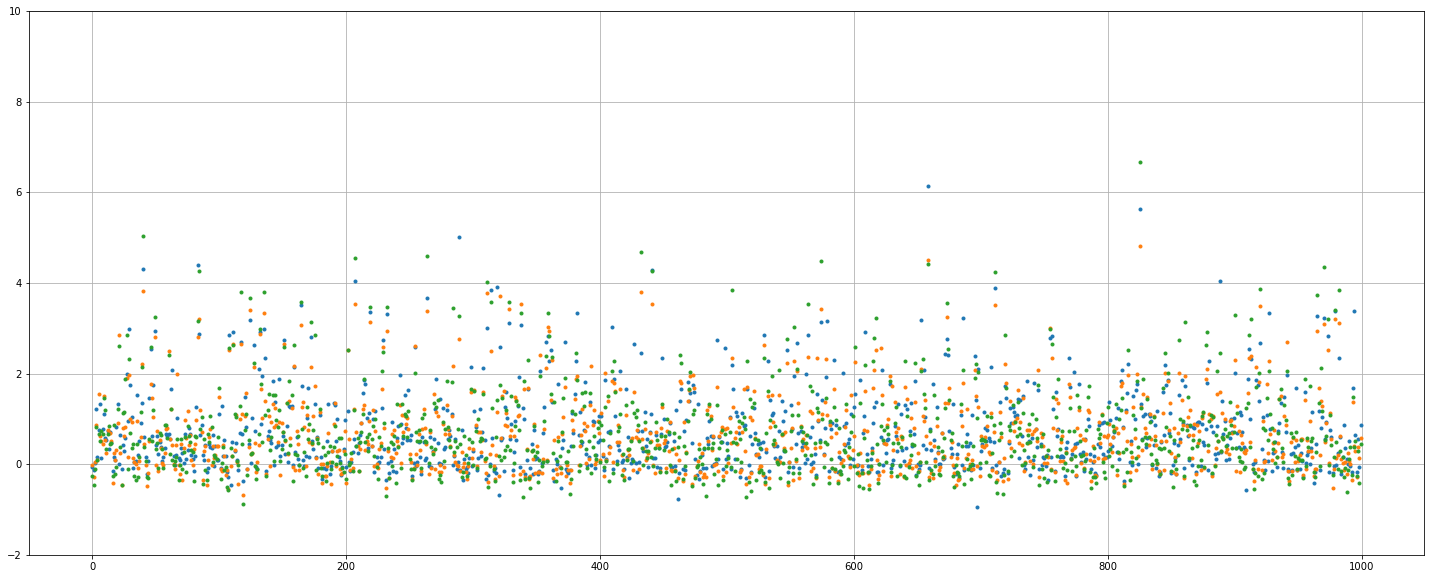

In [37]:
plt.figure(figsize=(25,10))
for color_idx, cell_name in enumerate(cell_names):
    plt.plot(out_dict[f'{cell_name}_pred'], '.', color=f'C{color_idx}')
    plt.ylim(-2,10)
plt.grid()
plt.show()

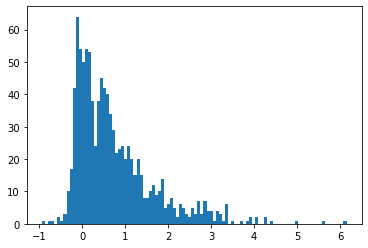

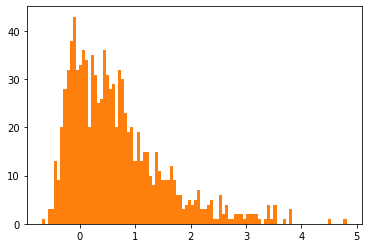

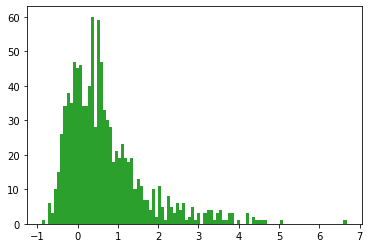

In [48]:
for color_idx, cell_name in enumerate(cell_names):
    plt.hist(out_dict[f'{cell_name}_pred'].numpy(), bins=100, color=f'C{color_idx}')
    plt.show()

In [49]:
torch.save(out_dict, 'random_sequences__contributions_dict.pt')